In [1]:
#!pip install

In [152]:
import pandas as pd
import numpy as np

#
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#
import seaborn as sns
import plotly.express as px

#
import os
import random
import re
import math
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback

#from pandas_summary import DataFrameSummary
#from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import warnings
from missingpy import MissForest
from PIL import Image

# loading modelling libraries

import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import awswrangler as wr
warnings.filterwarnings('ignore') 
%matplotlib notebook
%matplotlib inline

In [131]:
seed_val = 101
random.seed(seed_val)
np.random.seed(seed_val)
# Setting color palette.
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]

# Setting plot styling.
plt.style.use('ggplot')
# expand pandas df rows/column widths etc.
pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False
             ) # disable Latex style mathjax rendering

###Load Non-Image Metadata

In [207]:
df = pd.read_csv('./all_data_split_3.csv', index_col = 0)
df.head()

,age_impute_mf,reds,greens,blues,mean_colors,missing_anatomy,missing_sex,missing_age,age_impute_mode,age_impute_median,age_impute_mean,age_impute_max,age_impute_min,label,sex_mf_female,sex_mf_male,anatomy_mf_abdomen,anatomy_mf_acral,anatomy_mf_back,anatomy_mf_chest,anatomy_mf_ear,anatomy_mf_face,anatomy_mf_foot,anatomy_mf_genital,anatomy_mf_hand,anatomy_mf_head/neck,anatomy_mf_lower extremity,anatomy_mf_neck,anatomy_mf_oral/genital,anatomy_mf_palms/soles,anatomy_mf_scalp,anatomy_mf_torso,anatomy_mf_trunk,anatomy_mf_upper extremity,sex_mode_female,sex_mode_male,anatomy_mode_abdomen,anatomy_mode_acral,anatomy_mode_back,anatomy_mode_chest,anatomy_mode_ear,anatomy_mode_face,anatomy_mode_foot,anatomy_mode_genital,anatomy_mode_hand,anatomy_mode_head/neck,anatomy_mode_lower extremity,anatomy_mode_neck,anatomy_mode_oral/genital,anatomy_mode_palms/soles,anatomy_mode_scalp,anatomy_mode_torso,anatomy_mode_trunk,anatomy_mode_upper extremity,path,split_3
0,80.0,208.736267,162.703426,181.659333,184.366342,0.0,0.0,0.0,80.0,80.0,80.0,80.0,80.0,Benign Marking or Mole,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0027419.jpg,NaN
1,80.0,197.138056,156.542415,177.196333,176.958935,0.0,0.0,0.0,80.0,80.0,80.0,80.0,80.0,Benign Marking or Mole,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0025030.jpg,NaN
2,80.0,214.053785,156.414959,174.070967,181.513237,0.0,0.0,0.0,80.0,80.0,80.0,80.0,80.0,Benign Marking or Mole,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0026769.jpg,NaN
3,80.0,195.708563,142.608015,157.175893,165.164157,0.0,0.0,0.0,80.0,80.0,80.0,80.0,80.0,Benign Marking or Mole,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0025661.jpg,NaN
4,75.0,211.709311,167.980289,185.249274,188.312958,0.0,0.0,0.0,75.0,75.0,75.0,75.0,75.0,Benign Marking or Mole,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0031633.jpg,NaN


In [208]:
#create a mapping from labels to a unique integer and vice versa for labelling and prediction later
labels = df['label'].sort_values(ascending=True).unique()
i = 0
idx2class = {} 
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i += 1
idx2class

{0: 'Benign Marking or Mole',
 1: 'Non-Cancerous Skin Condition',
 2: 'Potentially Malignant Skin Tumors',
 3: 'Toxin, Fungal, Bug, Viral, or Bacterial Infections',
 4: 'Unclassified'}

In [209]:
df['label'] = df['label'].replace(class2idx)
df.head()

,age_impute_mf,reds,greens,blues,mean_colors,missing_anatomy,missing_sex,missing_age,age_impute_mode,age_impute_median,age_impute_mean,age_impute_max,age_impute_min,label,sex_mf_female,sex_mf_male,anatomy_mf_abdomen,anatomy_mf_acral,anatomy_mf_back,anatomy_mf_chest,anatomy_mf_ear,anatomy_mf_face,anatomy_mf_foot,anatomy_mf_genital,anatomy_mf_hand,anatomy_mf_head/neck,anatomy_mf_lower extremity,anatomy_mf_neck,anatomy_mf_oral/genital,anatomy_mf_palms/soles,anatomy_mf_scalp,anatomy_mf_torso,anatomy_mf_trunk,anatomy_mf_upper extremity,sex_mode_female,sex_mode_male,anatomy_mode_abdomen,anatomy_mode_acral,anatomy_mode_back,anatomy_mode_chest,anatomy_mode_ear,anatomy_mode_face,anatomy_mode_foot,anatomy_mode_genital,anatomy_mode_hand,anatomy_mode_head/neck,anatomy_mode_lower extremity,anatomy_mode_neck,anatomy_mode_oral/genital,anatomy_mode_palms/soles,anatomy_mode_scalp,anatomy_mode_torso,anatomy_mode_trunk,anatomy_mode_upper extremity,path,split_3
0,80.0,208.736267,162.703426,181.659333,184.366342,0.0,0.0,0.0,80.0,80.0,80.0,80.0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0027419.jpg,NaN
1,80.0,197.138056,156.542415,177.196333,176.958935,0.0,0.0,0.0,80.0,80.0,80.0,80.0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0025030.jpg,NaN
2,80.0,214.053785,156.414959,174.070967,181.513237,0.0,0.0,0.0,80.0,80.0,80.0,80.0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0026769.jpg,NaN
3,80.0,195.708563,142.608015,157.175893,165.164157,0.0,0.0,0.0,80.0,80.0,80.0,80.0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0025661.jpg,NaN
4,75.0,211.709311,167.980289,185.249274,188.312958,0.0,0.0,0.0,75.0,75.0,75.0,75.0,75.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_and_2/ISIC_0031633.jpg,NaN


In [210]:
train = df[~df['split_3'].isin(['test', 'val'])]
val = df[df['split_3'].isin(['val'])]
test = df[df['split_3'].isin(['test'])]
train.shape

(56583, 56)

###Cross Validate on Accuracy

In [211]:
X = train.drop(['label', 'split_3', 'path'], axis=1)
y = train.label
# taking holdout set for validating with stratified y

X_train, X_holdout, y_train, y_holdout = train_test_split(X,
                                                    y,
                                                    test_size=0.01,
                                                    stratify=y,
                                                    random_state=42)

# 5 fold stratify for cv
cv = StratifiedKFold(5, shuffle=True, random_state=42)

In [212]:
X_test = test.drop(['label', 'split_3', 'path'], axis=1)
y_test = test.label
X_val = val.drop(['label', 'split_3', 'path'], axis=1)
y_val = val.label

In [213]:
# setting model hyperparameters, didn't include fine tuning here because of timing reasons...
# original parameters
# xg = xgb.XGBClassifier(
#     n_estimators=750,
#     min_child_weight=0.81,
#     learning_rate=0.025,
#     max_depth=2,
#     subsample=0.80,
#     colsample_bytree=0.42,
#     gamma=0.10,
#     random_state=42,
#     n_jobs=-1,
# )

In [214]:
# final model parameters
xg = xgb.XGBClassifier(
    n_estimators=750,
    min_child_weight=1.2,
    learning_rate=0.040,
    max_depth=3,
    subsample=0.80,
    colsample_bytree=0.6,
    gamma=0.25,
    random_state=42,
    n_jobs=-1,
    objective='multi:softmax',
    nthread=4
)
estimators = [xg]

In [215]:
# cross validation scheme

def model_check(X_train, y_train, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    scoring='accuracy',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index,
                        'Train accuracy'] = cv_results['train_score'].mean()
        model_table.loc[row_index,
                        'Validation accuracy'] = cv_results['test_score'].mean()
        model_table.loc[row_index, 'Validation Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Validation accuracy'],
                            ascending=False,
                            inplace=True)

    return model_table

In [216]:
# display cv results

raw_models = model_check(X_train, y_train, estimators, cv)
display(raw_models)

,Model Name,Train accuracy,Validation accuracy,Validation Std,Time
0,XGBClassifier,0.778152,0.763911,0.003297,158.189294


### Result on Validation Group

In [217]:
xg.fit(X, y)

# predicting on holdout set
y_pred = xg.predict(X_val)

# checking results on test set
accuracy_score(y_val, y_pred)

0.4722222222222222

### Result on Test Group

In [218]:
xg.fit(X, y)

# predicting on holdout set
y_pred = xg.predict(X_test)

# checking results on test set
accuracy_score(y_test, y_pred)

0.48

### Confusion Matrix

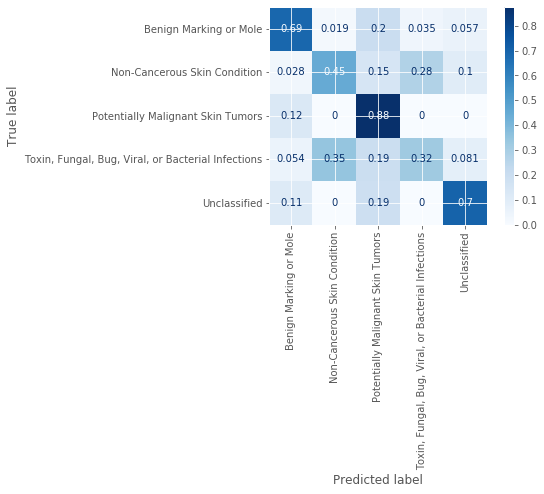

In [219]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=[i for i in idx2class.values()], 
                                        xticks_rotation = "vertical", cmap='Blues' , normalize = "true")
plt.show()

### Save the model

In [220]:
import pickle
model = xg
filename = 'finalized_meta.sav'
pickle.dump(model, open(filename, 'wb'))

In [120]:
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, y_test)
# print(result)

0.7354535890588331


### Learning Curve

In [31]:
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit


# def plot_learning_curve(
#     estimator,
#     title,
#     X,
#     y,
#     axes=None,
#     ylim=None,
#     cv=None,
#     n_jobs=None,
#     scoring=None,
#     train_sizes=np.linspace(0.1, 1.0, 5),
# ):

#     if axes is None:
#         _, axes = plt.subplots(1, 1, figsize=(10, 5))

#     axes.set_title(title)
#     if ylim is not None:
#         axes.set_ylim(*ylim)
#     axes.set_xlabel("Training examples")
#     axes.set_ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
#         estimator,
#         X,
#         y,
#         scoring=scoring,
#         cv=cv,
#         n_jobs=n_jobs,
#         train_sizes=train_sizes,
#         return_times=True,
#     )
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     # Plot learning curve
#     axes.grid()
#     axes.fill_between(
#         train_sizes,
#         train_scores_mean - train_scores_std,
#         train_scores_mean + train_scores_std,
#         alpha=0.1,
#         color="r",
#     )
#     axes.fill_between(
#         train_sizes,
#         test_scores_mean - test_scores_std,
#         test_scores_mean + test_scores_std,
#         alpha=0.1,
#         color="g",
#     )
#     axes.plot(
#         train_sizes, train_scores_mean, "o-", color="r", label="Training score"
#     )
#     axes.plot(
#         train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
#     )
#     axes.legend(loc="best")

#     return plt


# fig, axes = plt.subplots(1, 1, figsize=(10, 5))

# X, y = X_train, y_train

# title = "Learning Curves"

# cv = ShuffleSplit(n_splits=20, test_size=0.1, random_state=0)

# plot_learning_curve(xg, title, X, y, axes=axes, ylim=(0.60, 0.80),
#                     cv=cv, n_jobs=4)

# plt.show()

### Gridsearch to finetune model hyperparameters

#### initial model parameters

In [32]:
# from xgboost.sklearn import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# xgb1 = XGBClassifier(
#     n_estimators=750,
#     min_child_weight=0.81,
#     learning_rate=0.025,
#     max_depth=2,
#     subsample=0.80,
#     colsample_bytree=0.42,
#     gamma=0.10,
#     random_state=42,
#     n_jobs=-1,
#     objective='multi:softmax',
#     nthread=4
# )

In [33]:
# def getTrainScores(gs):
#     results = {}
#     runs = 0
#     for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
#         results[runs] = 'mean:' + str(x) + 'params' + str(y)
#         runs += 1
#     best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
#     return results, best

#### grid search new parameters

In [34]:
# param_test1 = {
#  'max_depth':range(1,5,1),
#  'min_child_weight':np.arange(0.5,3.0,0.5)
# }
# #metrics to consider: f1_micro, f1_macro, roc_auc_ovr
# gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='accuracy', n_jobs=-1, verbose = 10, cv=5)
# gsearch1.fit(X_train, y_train)
# getTrainScores(gsearch1)

In [35]:
# param_test2 = {
#  'max_depth':range(4,8,1),
#  'min_child_weight':np.arange(1.2,2.0,0.2)
# }
# #metrics to consider: f1_micro, f1_macro, roc_auc_ovr
# gsearch2 = GridSearchCV(estimator = xgb1, param_grid = param_test2, scoring='accuracy', n_jobs=-1, verbose = 10, cv=5)
# gsearch2.fit(X_train, y_train)
# getTrainScores(gsearch2)

#### second model

In [36]:
# xgb2 = XGBClassifier(
#     n_estimators=750,
#     min_child_weight=1.2,
#     learning_rate=0.025,
#     max_depth=7,
#     subsample=0.80,
#     colsample_bytree=0.42,
#     gamma=0.10,
#     random_state=42,
#     n_jobs=-1,
#     objective='multi:softmax',
#     nthread=4
# )

In [37]:
# param_test3 = {
#  'learning_rate':np.arange(0.016,0.036,0.002)
# }
# #metrics to consider: f1_micro, f1_macro, roc_auc_ovr
# gsearch3 = GridSearchCV(estimator = xgb2, param_grid = param_test3, scoring='accuracy', n_jobs=-1, verbose = 10, cv=5)
# gsearch3.fit(X_train, y_train)
# getTrainScores(gsearch3)

In [38]:
# xgb3 = XGBClassifier(
#     n_estimators=750,
#     min_child_weight=1.2,
#     learning_rate=0.040,
#     max_depth=8,
#     subsample=0.80,
#     colsample_bytree=0.42,
#     gamma=0.25,
#     random_state=42,
#     n_jobs=-1,
#     objective='multi:softmax',
#     nthread=4
# )

In [42]:
# param_test4 = {
#  'colsample_bytree':np.arange(0.1, 1.0, 0.1)
# }
# #metrics to consider: f1_micro, f1_macro, roc_auc_ovr
# gsearch4 = GridSearchCV(estimator = xgb3, param_grid = param_test4, scoring='accuracy', n_jobs=-1, verbose = 10, cv=5)
# gsearch4.fit(X_train, y_train)
# getTrainScores(gsearch4)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({0: "mean:0.7226988459506172params{'colsample_bytree': 0.1}",
  1: "mean:0.7352068667536458params{'colsample_bytree': 0.2}",
  2: "mean:0.7379730224575654params{'colsample_bytree': 0.30000000000000004}",
  3: "mean:0.7392158468787693params{'colsample_bytree': 0.4}",
  4: "mean:0.7406791483309989params{'colsample_bytree': 0.5}",
  5: "mean:0.7416412669966741params{'colsample_bytree': 0.6}",
  6: "mean:0.7414609203493149params{'colsample_bytree': 0.7000000000000001}",
  7: "mean:0.7410198979802273params{'colsample_bytree': 0.8}",
  8: "mean:0.740318302349965params{'colsample_bytree': 0.9}"},
 {'best_mean': 0.7416412669966741, 'best_param': {'colsample_bytree': 0.6}})

### final model parameters

In [ ]:
# xgb3 = XGBClassifier(
#     n_estimators=750,
#     min_child_weight=1.2,
#     learning_rate=0.040,
#     max_depth=8,
#     subsample=0.80,
#     colsample_bytree=0.6,
#     gamma=0.25,
#     random_state=42,
#     n_jobs=-1,
#     objective='multi:softmax',
#     nthread=4
# )

### Compute learning curve after parameter tuning

In [40]:
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit


# def plot_learning_curve(
#     estimator,
#     title,
#     X,
#     y,
#     axes=None,
#     ylim=None,
#     cv=None,
#     n_jobs=None,
#     scoring=None,
#     train_sizes=np.linspace(0.1, 1.0, 5),
# ):

#     if axes is None:
#         _, axes = plt.subplots(1, 1, figsize=(10, 5))

#     axes.set_title(title)
#     if ylim is not None:
#         axes.set_ylim(*ylim)
#     axes.set_xlabel("Training examples")
#     axes.set_ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
#         estimator,
#         X,
#         y,
#         scoring=scoring,
#         cv=cv,
#         n_jobs=n_jobs,
#         train_sizes=train_sizes,
#         return_times=True,
#     )
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     # Plot learning curve
#     axes.grid()
#     axes.fill_between(
#         train_sizes,
#         train_scores_mean - train_scores_std,
#         train_scores_mean + train_scores_std,
#         alpha=0.1,
#         color="r",
#     )
#     axes.fill_between(
#         train_sizes,
#         test_scores_mean - test_scores_std,
#         test_scores_mean + test_scores_std,
#         alpha=0.1,
#         color="g",
#     )
#     axes.plot(
#         train_sizes, train_scores_mean, "o-", color="r", label="Training score"
#     )
#     axes.plot(
#         train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
#     )
#     axes.legend(loc="best")

#     return plt


# fig, axes = plt.subplots(1, 1, figsize=(10, 5))

# X, y = X_train, y_train

# title = "Learning Curves"

# cv = ShuffleSplit(n_splits=20, test_size=0.1, random_state=0)

# plot_learning_curve(xgb3, title, X, y, axes=axes, ylim=(0.60, 0.80),
#                     cv=cv, n_jobs=4)

# plt.show()

### Feature Importance

In [41]:
# # finding feature importances and creating new dataframe basen on them

# feature_importance = xg.get_booster().get_score(importance_type='weight')

# keys = list(feature_importance.keys())
# values = list(feature_importance.values())

# importance = pd.DataFrame(data=values, index=keys,
#                           columns=['score']).sort_values(by='score',
#                                                          ascending=False)
# fig, ax = plt.subplots(figsize=(16, 10))
# sns.barplot(x=importance.score.iloc[:20],
#             y=importance.index[:20],
#             orient='h',
#             palette='Reds_r')
# ax.set_title('Feature Importances')
# plt.show()

NotFittedError: need to call fit or load_model beforehand